In [2]:
import torch
import torch.nn as nn 
import time 
from transformers import GPT2LMHeadModel, GPT2Tokenizer

C:\Users\dhanu\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

model = GPT2LMHeadModel.from_pretrained("gpt2")

In [4]:
prompt = "DeepSeek is a revolutionary search engine that leverages the power of AI to provide users with the most relevant and accurate search results. Unlike traditional search engines that rely on keyword matching, DeepSeek uses advanced natural language processing techniques to understand the context and intent behind each query. This allows it to deliver results that are not only more precise but also more personalized to the user's needs. With its intuitive interface and lightning-fast response times, DeepSeek is poised to become the go-to search engine for users around the world."


In [5]:
inputs = tokenizer(prompt, return_tensors="pt")


In [6]:
input_ids = inputs.input_ids

In [7]:
print(f'Input IDs shape: {input_ids.shape}')  # (1, sequence_length)

Input IDs shape: torch.Size([1, 108])


In [8]:
for _ in range(20):
    # Pass the entire sequence to the model
    outputs = model(input_ids)
    logits = outputs.logits

    # Get the logits for the very last token
    next_token_logits = logits[:, -1, :]

    # Get the ID of the most likely next token (greedy decoding)
    next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

    # Append the new token ID to the input sequence
    input_ids = torch.cat([input_ids, next_token_id], dim=-1)

    # Decode and print the new token
    new_token = tokenizer.decode(next_token_id[0])
    print(new_token, end="", flush=True)



DeepSeek is a revolutionary search engine that leverages the power of AI to provide users

# token by toekn generation process in a autoregressive model .
* entire sequence is passed through the model at each step
* extract only the logits for last token position
* select the most likely next token 
* append this token to our sequence and repeat 



In [9]:
# speedup of kv caching

prompt = "DeepSeek is a revolutionary search engine that leverages the power of AI to provide users with the most relevant and accurate search results. Unlike traditional search engines that rely on keyword matching, DeepSeek uses advanced natural language processing techniques to understand the context and intent behind each query. This allows it to deliver results that are not only more precise but also more personalized to the user's needs. With its intuitive interface and lightning-fast response times, DeepSeek is poised to become the go-to search engine for users around the world."
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs.input_ids
attention_mask = inputs.attention_mask

In [10]:
#time wihtout kv caching

start_time_without_cache = time.time()

output_without_cache = model.generate(
    input_ids=input_ids,
    max_new_tokens = 100,
    use_cache=False,
    attention_mask=attention_mask
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [11]:
end_time_without_cache = time.time()
duration_without_cache = end_time_without_cache - start_time_without_cache
print(f"\nTime taken without KV caching: {duration_without_cache:.4f} seconds")


Time taken without KV caching: 20.6008 seconds


In [12]:
# timing with kv caching
start_time_with_cache = time.time()
output_with_cache = model.generate(
    input_ids=input_ids,
    max_new_tokens=100,
    use_cache=True,
    attention_mask=attention_mask
)
end_time_with_cache = time.time()
duration_with_cache = end_time_with_cache - start_time_with_cache
print(f"Time taken with KV caching: {duration_with_cache:.4f} seconds")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Time taken with KV caching: 7.0046 seconds


In [13]:
#calculate and print time with kv caching
speedup = duration_without_cache / duration_with_cache
print(f"Speedup with KV caching: {speedup:.2f}x")

Speedup with KV caching: 2.94x


# Key value caching : the first generation solution

The key-value (KV) cache is the foundational technique for addressing the inference bottleneck in transformer models like DeepSeek. The key insight is simple but powerful:

Since previous tokens don't change during generation, their key and value projections can be computed once and reused.

How KV Caching Works:

Initial Computation: For the first token, compute Q, K, V as usual

Storage: Save the K, V tensors in a "cache"

Subsequent Tokens:

Only compute Q, K, V for the new token

Retrieve previous K, V from the cache

Concatenate the new K, V with the cached ones

Store the expanded K, V in the cache

Result: Each new token only needs to compute its own key-value pair rather 
than recomputing for all tokens

This reduces the computational complexity from O(n²) to O(n) per token, where n is the sequence length.

Ememory computation trade off : 
the kv cache trades increased memory usage for significantly reduced computations :

* MEmory usage : Increase linearly with sequence length 
* Computation : Dramatically reduced for long sequences


# From KV Cache to advanced attention mecahnusm 

while the key value cache improves inference speed,models like Deepseek required optimization to handle their massive scale efficiently .The KV cache serves as the foundations for more advanced attention mechanism 

The Evolution Path : 

* KV  cache (first generation) : The basic optimization that have explored
* multi query attention : shared K/V projection across attention heads
* Grouped- query attention : A middle ground between standard attention and MQA 
* Multi Head Latent Attention : Advanced tech 


# Multi Query Attention (MQA) :

Standard multi head attention required unique K,V projection for each attention head which increases the KV cache size proportionally to the number of heads . MQA address this by : 
* Using a single shared K,v projection across all the attention heads 
* Maination separate Q projection for each head

this significantly reduces the memory requirements during the inference while maintaining the most of the model's accuracy

# Group Query Attention :

While MQA significantly reduces the memory usage ,it can sometimes degrade model quality .Deepseek models use Grouped query attention as balanced approach :

* Group Attention heads into clusers 
* Each group shares the same K,V projection
* Queris reman separate for each head

GQA offers favorable trade off :

* Better quality than MQA 
* More efficient than standard multi head attention 
* Well suited for Deepseek massive scale

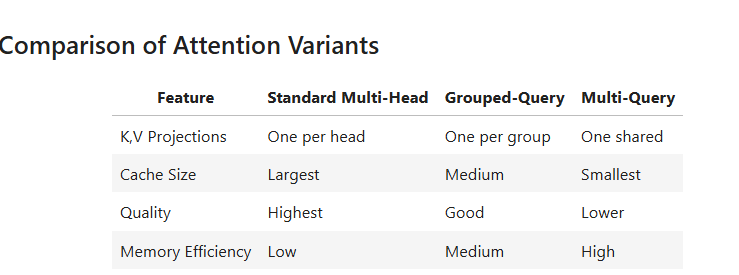

In [22]:
# impementing an MQA layers from scratch

class MultiQueryAttention(nn.Module):
    def __init__(self,d_model,num_heads,dropout = 0.0):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, self.d_head)
        self.W_v = nn.Linear(d_model, self.d_head)

        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask',torch.triu(torch.ones(1,1,1024,1024),diagonal = 1))

    def forward(self, x):
        batch_size ,seq_len, d_model = x.size()

        # query : (B, num_heads,seq_len, d_head)

        q = self.W_q(x).view(batch_size, seq_len,self.num_heads,self.d_head).transpose(1,2)
        # key, value : (B, 1, seq_len, d_head)
        k = self.W_k(x).view(batch_size, seq_len,1,self.d_head).transpose(1,2)
        v = self.W_v(x).view(batch_size, seq_len,1,self.d_head).transpose(1,2)

        #repeat K and V for each query head
        k = k.repeat(1,self.num_heads,1,1)
        v = v.repeat(1,self.num_heads,1,1)

        attn_scores = (q @ k.transpose(-2,-1)) / (self.d_head ** 0.5)

        #apply casual mask

        attn_scores = attn_scores.masked_fill(self.mask[:,:,:seq_len,:seq_len] == 0, float('-inf'))

        # Compute attention weights (softmax over last dimension)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vector = (attn_weights @ v).transpose(1,2).contiguous().view(batch_size,seq_len,self.d_model)
        output = self.W_o(context_vector)
        return output
        

In [23]:
d_model = 512
num_heads = 8
batch_size = 2
seq_len = 64


In [24]:
mqa_layer = MultiQueryAttention(d_model,num_heads,dropout=0.1)
dummy_input = torch.randn(batch_size,seq_len,d_model)
output = mqa_layer(dummy_input)

print(f"Output shape: {output.shape}")  # Should be (batch_size, seq_len, d_model)
# --- IGNORE ---
# Autoregressive Generation with Optimizations


Output shape: torch.Size([2, 64, 512])


# Multi Query Attention (MQA) :

1. Query projection maps to the full model dimension 
2. Key and value projection map to just a single head dimenstion 
3. We use repeat() to duplicate the single key and value for all the query heads

In [34]:
class GroupedQueryAttention(nn.Module):
    def __init__(self, d_model, num_heads, num_groups, dropout=0.0, max_seq_len: int = 1024):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        assert num_heads % num_groups == 0, "num_heads must be divisible by num_groups"

        self.d_model = d_model
        self.num_heads = num_heads
        self.num_groups = num_groups
        self.d_head = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, self.num_groups * self.d_head) # Grouped projection for K
        self.W_v = nn.Linear(d_model, self.num_groups * self.d_head) # Grouped projection for V
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self._register_mask_buffer(max_seq_len)

    def _register_mask_buffer(self, max_seq_len):
        if max_seq_len > 0:
            mask = torch.triu(torch.ones(1, 1, max_seq_len, max_seq_len, dtype=torch.bool), diagonal=1)
            self.register_buffer("causal_mask", mask, persistent=False)
        else:
            self.causal_mask = None

    def _get_causal_mask(self, seq_len, device):
        if self.causal_mask is not None and self.causal_mask.size(-1) >= seq_len:
            return self.causal_mask[:, :, :seq_len, :seq_len]
        # Dynamically create mask if needed
        return torch.triu(torch.ones(1, 1, seq_len, seq_len, dtype=torch.bool, device=device), diagonal=1)

    def forward(self, x):
        B, T, _ = x.shape

        # Query: (B, num_heads, T, d_head)
        q = self.W_q(x).view(B, T, self.num_heads, self.d_head).transpose(1, 2)

        # Key & Value: (B, num_groups, T, d_head)
        k = self.W_k(x).view(B, T, self.num_groups, self.d_head).transpose(1, 2)
        v = self.W_v(x).view(B, T, self.num_groups, self.d_head).transpose(1, 2)

        heads_per_group = self.num_heads // self.num_groups

        # Repeat K and V to match query heads
        k = k.repeat_interleave(heads_per_group, dim=1) # (B, num_heads, T, d_head)
        v = v.repeat_interleave(heads_per_group, dim=1) # (B, num_heads, T, d_head)

        attn_scores = (q @ k.transpose(-2, -1)) * (self.d_head**-0.5)

        causal_mask = self._get_causal_mask(T, x.device)
        attn_scores = attn_scores.masked_fill(causal_mask, float("-inf"))

        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context = (attn_weights @ v).transpose(1, 2).contiguous().view(B, T, self.d_model)

        return self.W_o(context)


In [35]:
# --- Usage Example ---
d_model = 512
num_heads = 32
num_groups = 4 # e.g., Llama 2 7B uses 4 groups for 32 heads
batch_size = 4
seq_len = 64

gqa_layer = GroupedQueryAttention(d_model, num_heads, num_groups)
dummy_input = torch.randn(batch_size, seq_len, d_model)
output = gqa_layer(dummy_input)

print("GQA Layer successful!")
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
     

GQA Layer successful!
Input shape: torch.Size([4, 64, 512])
Output shape: torch.Size([4, 64, 512])


## Implementing Grouped-Query Attention (GQA)

The code below implements a Grouped-Query Attention layer from scratch. Note the key differences:

Query projection (self.W_q) still maps to the full model dimension

Key and value projections (self.W_k and self.W_v) map to self.num_groups * self.d_head
We use repeat_interleave() to match each key and value group with its corresponding query heads
This implementation demonstrates how GQA balances between standard multi-head attention and MQA:

Fewer K,V projections than standard attention (reduced by factor of num_heads/num_groups)
More K,V diversity than MQA (one set per group rather than just one shared)
DeepSeek models use this approach to maintain quality while reducing memory requirements, especially for the KV cache